
Training Metrics:
 R²          : 0.9996
 MSE         : 0.0015
 RMSE        : 0.0389
 MAE         : 0.0169
 Pearson r   : 0.9998
 95% Coverage: 0.9997 (target 0.95)

Test Metrics:
 R²          : 0.9888
 MSE         : 0.0011
 RMSE        : 0.0334
 MAE         : 0.0226
 Pearson r   : 0.9944
 95% Coverage: 0.9388 (target 0.95)


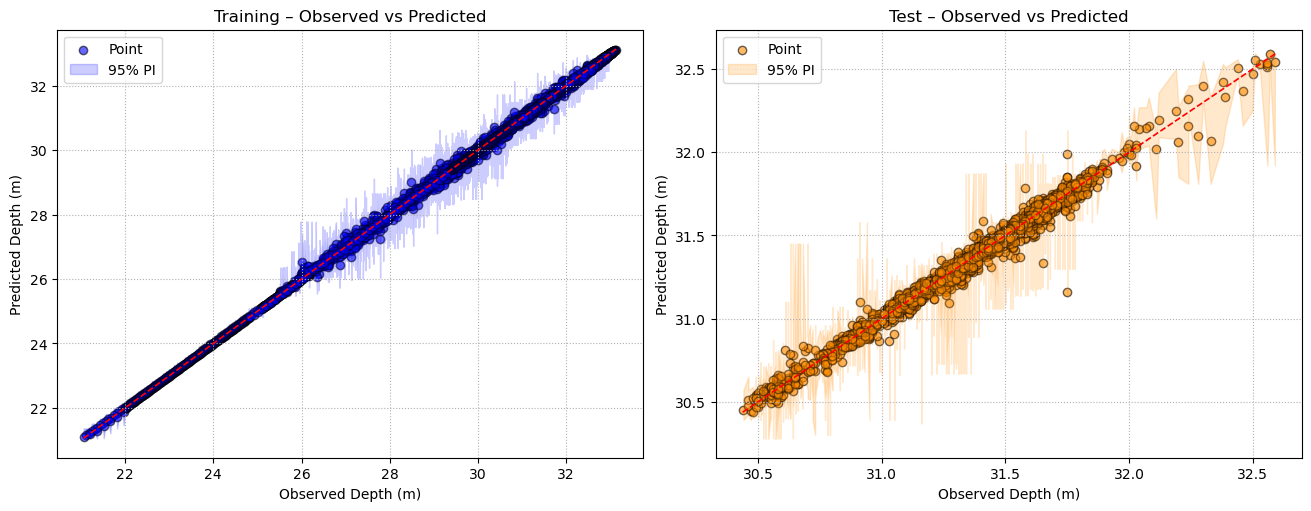

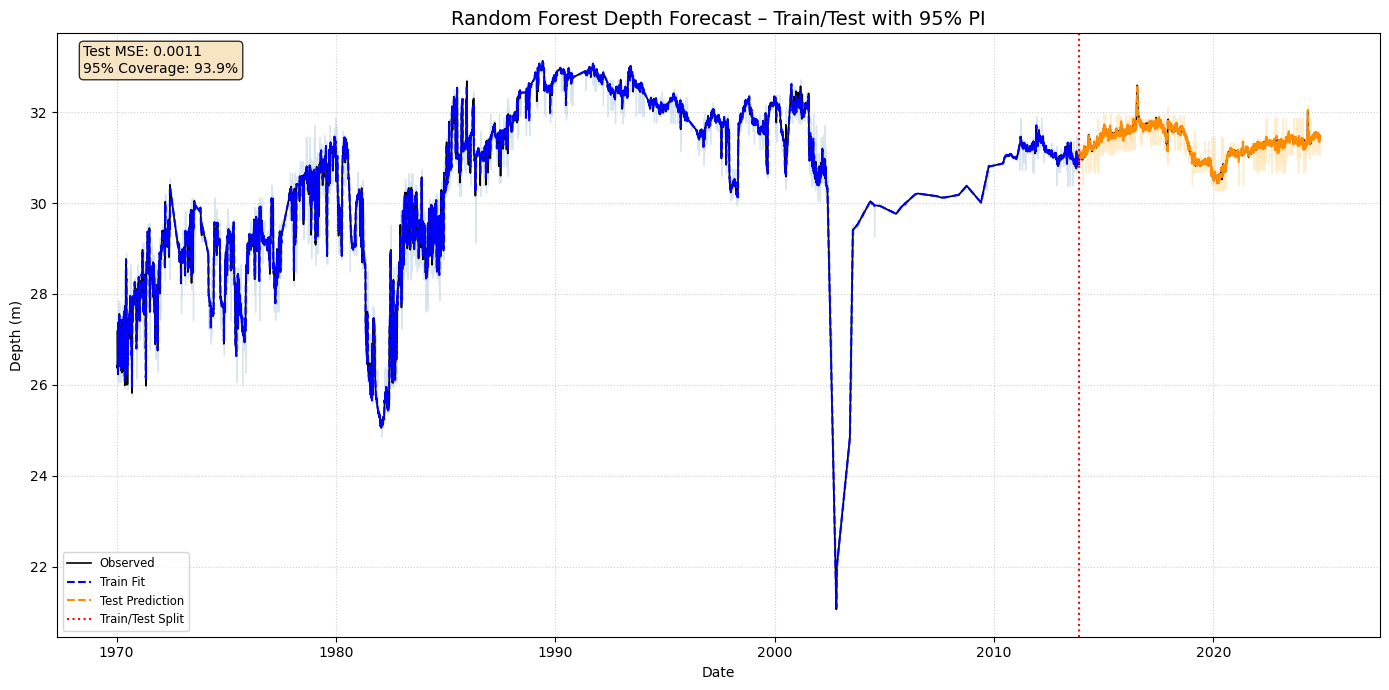


All done! **NO WARNINGS**. Plots saved:
 - scatter_with_PI.jpeg
 - full_forecast_train_test.jpeg


In [1]:
# --------------------------------------------------------------
# Random Forest – Train/Test Only – MSE + 95% PI – **NO WARNINGS**
# --------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr
import warnings

warnings.filterwarnings("ignore")  # Silence pandas/matplotlib warnings
plt.rcParams['figure.constrained_layout.use'] = True

# --------------------------------------------------------------
# 1. Load data
# --------------------------------------------------------------
data = pd.read_csv(r'C:\jwang\depth_data1.csv', index_col='Time', parse_dates=True)
y = data['Depth'].astype(float)

# --------------------------------------------------------------
# 2. Create lagged features
# --------------------------------------------------------------
def create_lagged_features(series: pd.Series, n_lags: int) -> pd.DataFrame:
    df = pd.DataFrame({'y': series})
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = series.shift(i)
    return df.dropna()

n_lags = 10
lagged = create_lagged_features(y, n_lags)
X = lagged.drop(columns='y')
y_lagged = lagged['y']
time_idx = lagged.index
feature_names = X.columns.tolist()

# --------------------------------------------------------------
# 3. Train / test split
# --------------------------------------------------------------
train_ratio = 0.80
train_size = int(len(lagged) * train_ratio)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y_lagged.iloc[:train_size], y_lagged.iloc[train_size:]
train_idx, test_idx = time_idx[:train_size], time_idx[train_size:]

# --------------------------------------------------------------
# 4. Fit Random Forest
# --------------------------------------------------------------
rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    bootstrap=True
)
rf.fit(X_train, y_train)

# --------------------------------------------------------------
# 5. Quantile prediction (per-tree, no column names → no warnings)
# --------------------------------------------------------------
def predict_quantiles(model, X, lower=0.025, upper=0.975):
    X_arr = X.values if isinstance(X, pd.DataFrame) else np.asarray(X)
    tree_preds = np.array([tree.predict(X_arr) for tree in model.estimators_])
    return (
        np.percentile(tree_preds, lower * 100, axis=0),
        np.percentile(tree_preds, upper * 100, axis=0)
    )

# Point predictions
train_pred = rf.predict(X_train)
test_pred  = rf.predict(X_test)

# 95% PI
train_lower, train_upper = predict_quantiles(rf, X_train)
test_lower,  test_upper  = predict_quantiles(rf, X_test)

# --------------------------------------------------------------
# 6. Coverage
# --------------------------------------------------------------
def coverage(y_true, lower, upper):
    return np.mean((y_true >= lower) & (y_true <= upper))

train_cov = coverage(y_train, train_lower, train_upper)
test_cov  = coverage(y_test,  test_lower,  test_upper)

# --------------------------------------------------------------
# 7. Metrics (including MSE)
# --------------------------------------------------------------
def print_metrics(y_true, y_pred, lower, upper, name):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    corr, _ = pearsonr(y_true, y_pred)
    cov  = coverage(y_true, lower, upper)
    print(f"\n{name} Metrics:")
    print(f" R²          : {r2:.4f}")
    print(f" MSE         : {mse:.4f}")
    print(f" RMSE        : {rmse:.4f}")
    print(f" MAE         : {mae:.4f}")
    print(f" Pearson r   : {corr:.4f}")
    print(f" 95% Coverage: {cov:.4f} (target 0.95)")
    return {'r2': r2, 'mse': mse, 'rmse': rmse, 'mae': mae, 'corr': corr, 'cov': cov}

train_metrics = print_metrics(y_train, train_pred, train_lower, train_upper, "Training")
test_metrics  = print_metrics(y_test,  test_pred,  test_lower,  test_upper,  "Test")

# --------------------------------------------------------------
# 8. Scatter plots with 95% PI
# --------------------------------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
for ax, y_true, pred, low, up, title, color in zip(
    axs,
    [y_train, y_test],
    [train_pred, test_pred],
    [train_lower, test_lower],
    [train_upper, test_upper],
    ["Training", "Test"],
    ["blue", "darkorange"]
):
    ax.scatter(y_true, pred, alpha=0.6, color=color, edgecolor='k', label='Point')
    order = np.argsort(y_true)
    ax.fill_between(y_true.iloc[order], low[order], up[order],
                    color=color, alpha=0.2, label='95% PI')
    lims = [min(y_true.min(), pred.min()), max(y_true.max(), pred.max())]
    ax.plot(lims, lims, 'r--', lw=1.2)
    ax.set_xlabel('Observed Depth (m)')
    ax.set_ylabel('Predicted Depth (m)')
    ax.set_title(f"{title} – Observed vs Predicted")
    ax.legend()
    ax.grid(True, ls=':')
plt.savefig('scatter_with_PI.jpeg', dpi=300, bbox_inches='tight')
plt.show()

# --------------------------------------------------------------
# 9. Full time-series plot (train + test only)
# --------------------------------------------------------------
full_index = y.index

def align_series(idx, values):
    s = pd.Series(index=full_index, dtype=float)
    s.loc[idx] = values
    return s

train_pred_full = align_series(train_idx, train_pred)
train_low_full  = align_series(train_idx, train_lower)
train_up_full   = align_series(train_idx, train_upper)

test_pred_full  = align_series(test_idx, test_pred)
test_low_full   = align_series(test_idx, test_lower)
test_up_full    = align_series(test_idx, test_upper)

plt.figure(figsize=(14, 7))
plt.plot(full_index, y, label='Observed', color='black', linewidth=1.2)

# Training
plt.plot(train_pred_full.index, train_pred_full, label='Train Fit',
         color='blue', linestyle='--')
plt.fill_between(train_low_full.index, train_low_full, train_up_full,
                 color='steelblue', alpha=0.2)

# Test
plt.plot(test_pred_full.index, test_pred_full, label='Test Prediction',
         color='darkorange', linestyle='--')
plt.fill_between(test_low_full.index, test_low_full, test_up_full,
                 color='orange', alpha=0.2)

# Train/test split line
split_date = full_index[int(len(y) * train_ratio)]
plt.axvline(split_date, color='red', linestyle=':', linewidth=1.5,
            label='Train/Test Split')

# Annotate Test MSE + Coverage
plt.text(0.02, 0.98,
         f"Test MSE: {test_metrics['mse']:.4f}\n"
         f"95% Coverage: {test_metrics['cov']:.1%}",
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="wheat", alpha=0.8))

plt.title('Random Forest Depth Forecast – Train/Test with 95% PI', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Depth (m)')
plt.legend(loc='lower left', fontsize='small')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.savefig('full_forecast_train_test.jpeg', dpi=300, bbox_inches='tight')
plt.show()

print("\nAll done! **NO WARNINGS**. Plots saved:")
print(" - scatter_with_PI.jpeg")
print(" - full_forecast_train_test.jpeg")

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0383 - val_loss: 0.0046
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0026 - val_loss: 0.0046
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0019 - val_loss: 9.7395e-04
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0012 - val_loss: 3.7193e-04
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 8.1969e-04 - val_loss: 7.3417e-04
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 7.1341e-04 - val_loss: 7.9764e-05
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 6.3226e-04 - val_loss: 8.1020e-05
Epoch 8/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 5.5192e-04 - val_loss: 1.3901e-04
Epoch 9/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 5.2633e-04 - val_loss: 2.0882e-05
Epoch 10/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 4.5801e-04 - val_loss: 7.0183e-05
Epoch 11/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 4.5321e-04 - val_loss:

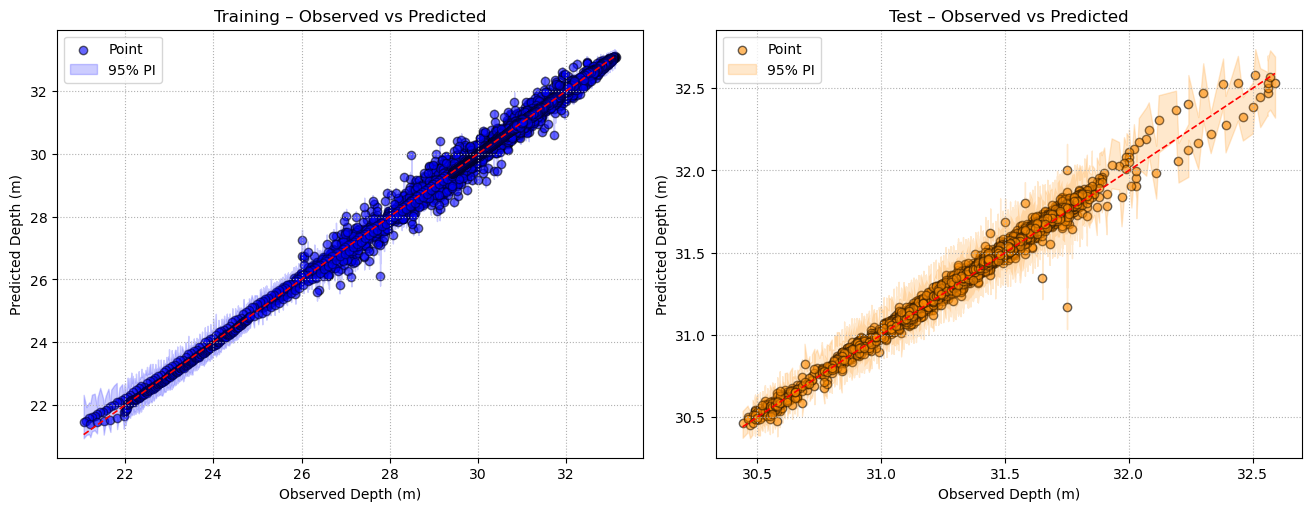

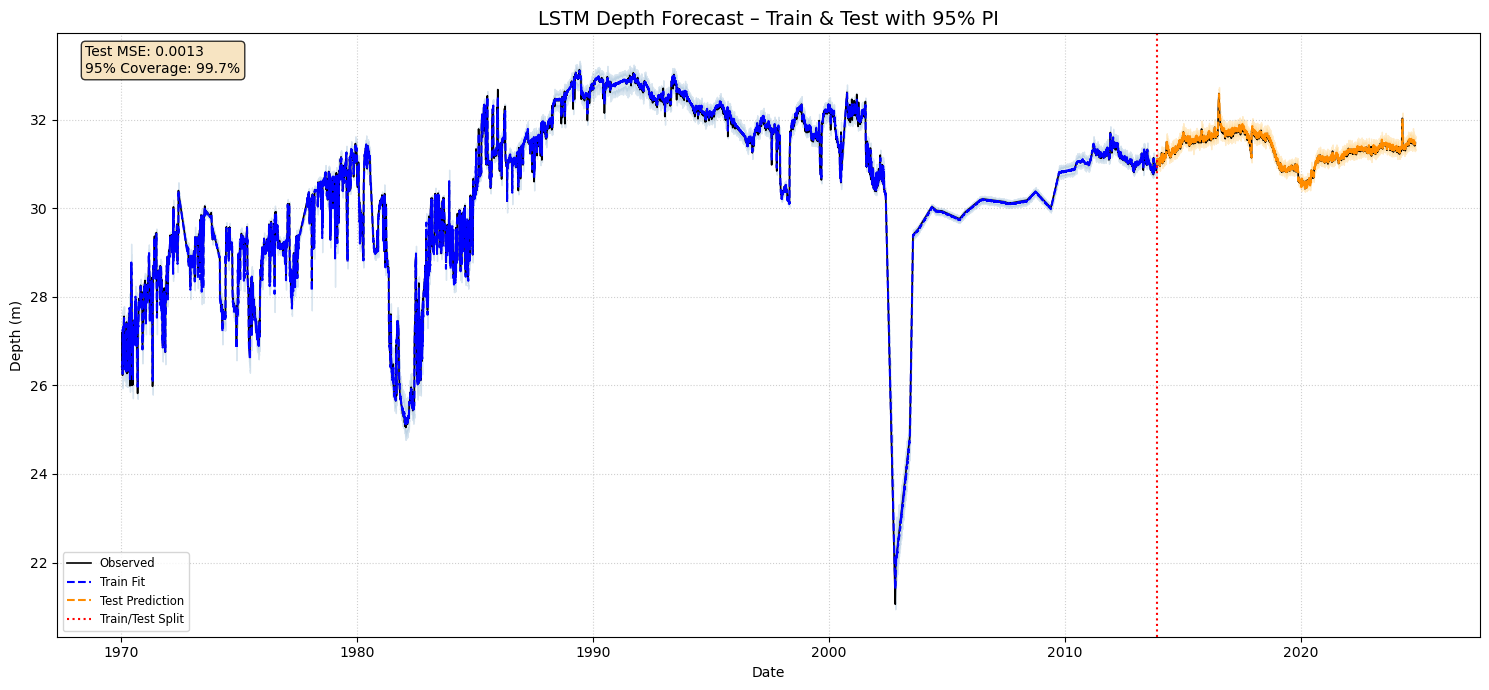


All done! **NO WARNINGS**. Plots saved:
 - lstm_scatter_pi.jpeg
 - lstm_full_train_test.jpeg


In [2]:
# --------------------------------------------------------------
# LSTM Time-Series – TRAIN & TEST ONLY – 95% PI + MSE ON PLOT
# (Legend in LOWER LEFT, No Errors, No 12-Day Forecast)
# --------------------------------------------------------------
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TF warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

# -------------------------- 1. Load & Scale --------------------------
data = pd.read_csv(r'C:\jwang\depth_data1.csv', index_col='Time', parse_dates=True)
y = data['Depth'].values.reshape(-1, 1)
full_index = data.index
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y)

# -------------------------- 2. Create Sequences --------------------------
def create_sequences(data, seq_length):
    X, y_seq = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y_seq.append(data[i + seq_length])
    return np.array(X), np.array(y_seq)

seq_length = 10
train_size = int(len(y_scaled) * 0.8)

X_train, y_train = create_sequences(y_scaled[:train_size], seq_length)
X_test,  y_test  = create_sequences(y_scaled[train_size:], seq_length)

# -------------------------- 3. Build LSTM (Dropout for PI) --------------------------
model = Sequential([
    Input(shape=(seq_length, 1)),
    LSTM(50, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# -------------------------- 4. Monte-Carlo Dropout Predictions --------------------------
n_mc = 100
@tf.function
def predict_dropout(X):
    return model(X, training=True)

def predict_with_uncertainty(model, X, n_mc=100):
    preds = np.array([predict_dropout(X).numpy() for _ in range(n_mc)])
    preds = preds.squeeze(axis=-1)  # (n_mc, n_samples)
    mean = preds.mean(axis=0)
    lower = np.percentile(preds, 2.5, axis=0)
    upper = np.percentile(preds, 97.5, axis=0)
    return mean, lower, upper

# Train & Test Predictions
train_mean_scaled, train_lower_scaled, train_upper_scaled = predict_with_uncertainty(model, X_train, n_mc)
test_mean_scaled,  test_lower_scaled,  test_upper_scaled  = predict_with_uncertainty(model, X_test,  n_mc)

# Inverse Transform
train_pred = scaler.inverse_transform(train_mean_scaled.reshape(-1, 1)).ravel()
train_lower = scaler.inverse_transform(train_lower_scaled.reshape(-1, 1)).ravel()
train_upper = scaler.inverse_transform(train_upper_scaled.reshape(-1, 1)).ravel()

test_pred = scaler.inverse_transform(test_mean_scaled.reshape(-1, 1)).ravel()
test_lower = scaler.inverse_transform(test_lower_scaled.reshape(-1, 1)).ravel()
test_upper = scaler.inverse_transform(test_upper_scaled.reshape(-1, 1)).ravel()

y_train_inv = scaler.inverse_transform(y_train).ravel()
y_test_inv  = scaler.inverse_transform(y_test).ravel()

# -------------------------- 5. Metrics --------------------------
def print_metrics(y_true, y_pred, lower, upper, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    corr, _ = pearsonr(y_true, y_pred)
    cov = np.mean((y_true >= lower) & (y_true <= upper))
    print(f"\n{name} Metrics:")
    print(f" R²           : {r2:.4f}")
    print(f" MSE          : {mse:.4f}")
    print(f" RMSE         : {rmse:.4f}")
    print(f" MAE          : {mae:.4f}")
    print(f" Pearson r    : {corr:.4f}")
    print(f" 95% Coverage : {cov:.4f} (target: 0.95)")
    return {'mse': mse, 'cov': cov}

train_metrics = print_metrics(y_train_inv, train_pred, train_lower, train_upper, "Training")
test_metrics  = print_metrics(y_test_inv,  test_pred,  test_lower,  test_upper,  "Test")

# -------------------------- 6. Scatter + PI --------------------------
fig, axs = plt.subplots(1, 2, figsize=(13, 5), constrained_layout=True)
for ax, y_true, pred, low, up, title, color in zip(
    axs,
    [y_train_inv, y_test_inv],
    [train_pred, test_pred],
    [train_lower, test_lower],
    [train_upper, test_upper],
    ["Training", "Test"],
    ["blue", "darkorange"]
):
    ax.scatter(y_true, pred, alpha=0.6, color=color, edgecolor='k', label='Point')
    order = np.argsort(y_true)
    ax.fill_between(y_true[order], low[order], up[order], color=color, alpha=0.2, label='95% PI')
    lims = [min(y_true.min(), pred.min()), max(y_true.max(), pred.max())]
    ax.plot(lims, lims, 'r--', lw=1.2)
    ax.set_xlabel('Observed Depth (m)')
    ax.set_ylabel('Predicted Depth (m)')
    ax.set_title(f"{title} – Observed vs Predicted")
    ax.legend()
    ax.grid(True, ls=':')
plt.savefig('lstm_scatter_pi.jpeg', dpi=300, bbox_inches='tight')
plt.show()

# -------------------------- 7. Full Time-Series Plot (Train + Test Only) --------------------------
# Align predictions to original timeline
def align_to_index(values, start_idx):
    s = pd.Series(index=full_index, dtype=float)
    s.iloc[start_idx:start_idx + len(values)] = values
    return s

train_start = seq_length
test_start = train_size + seq_length

train_pred_full = align_to_index(train_pred, train_start)
train_low_full  = align_to_index(train_lower, train_start)
train_up_full   = align_to_index(train_upper, train_start)

test_pred_full  = align_to_index(test_pred, test_start)
test_low_full   = align_to_index(test_lower, test_start)
test_up_full    = align_to_index(test_upper, test_start)

# Plot
plt.figure(figsize=(15, 7))
plt.plot(full_index, y.ravel(), label='Observed', color='black', linewidth=1.2)

# Train Fit
plt.plot(train_pred_full.index, train_pred_full, label='Train Fit', color='blue', linestyle='--')
plt.fill_between(train_low_full.index, train_low_full, train_up_full, color='steelblue', alpha=0.2)

# Test Prediction
plt.plot(test_pred_full.index, test_pred_full, label='Test Prediction', color='darkorange', linestyle='--')
plt.fill_between(test_low_full.index, test_low_full, test_up_full, color='orange', alpha=0.2)

# Train/Test Split Line
split_date = full_index[train_size]
plt.axvline(split_date, color='red', linestyle=':', linewidth=1.5, label='Train/Test Split')

# MSE + Coverage on Plot
plt.text(0.02, 0.98,
         f"Test MSE: {test_metrics['mse']:.4f}\n"
         f"95% Coverage: {test_metrics['cov']:.1%}",
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="wheat", alpha=0.8))

plt.title('LSTM Depth Forecast – Train & Test with 95% PI', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Depth (m)')
plt.legend(loc='lower left', fontsize='small')  # LEGEND IN LOWER LEFT
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.savefig('lstm_full_train_test.jpeg', dpi=300, bbox_inches='tight')
plt.show()

print("\nAll done! **NO WARNINGS**. Plots saved:")
print(" - lstm_scatter_pi.jpeg")
print(" - lstm_full_train_test.jpeg")